# **Task 2**

## **Import dependencies**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import torch
from transformers import DistilBertTokenizer, DistilBertModel, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

## **Data loading and Exploration**

In [ ]:
# Load the dataset
df = pd.read_csv('/content/comp1804_coursework_dataset_24-25.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns}")
print("\nClass distribution:")
print(df['petition_topic'].value_counts(normalize=True))

Dataset shape: (8898, 8)

Column names: Index(['petition_ID', 'has_entity', 'relevant_department',
       'deviation_across_regions', 'petition_status', 'petition_topic',
       'petition_importance', 'petition_text'],
      dtype='object')

Class distribution:
petition_topic
environment and animal welfare    0.269426
health and social care            0.239991
economy, labour and welfare       0.138942
education                         0.136123
culture, sport and media          0.119770
uk government and devolution      0.083568
london                            0.006879
Health And Social Care            0.001692
Environment And Animal Welfare    0.001466
Economy, Labour And Welfare       0.000677
Culture, Sport And Media          0.000564
Education                         0.000564
Uk Government And Devolution      0.000226
London                            0.000113
Name: proportion, dtype: float64


## **Data Splitting and Cleaning**

Top correlations with petition importance:
importance                                                                          1.000000
cat__relevant_department_Department of Health and Social Care                       0.379980
cat__petition_topic_uk government and devolution                                    0.379980
num__deviation_across_regions                                                       0.364606
cat__relevant_department_Department for Education                                   0.301511
cat__petition_topic_education                                                       0.301511
cat__relevant_department_Department for Business, Energy and Industrial Strategy    0.253629
cat__petition_topic_health and social care                                          0.207514
cat__relevant_department_Department for Digital, Culture, Media and Sport           0.207514
cat__relevant_department_Department for Energy Security and Net Zero                0.207514
dtype: float64


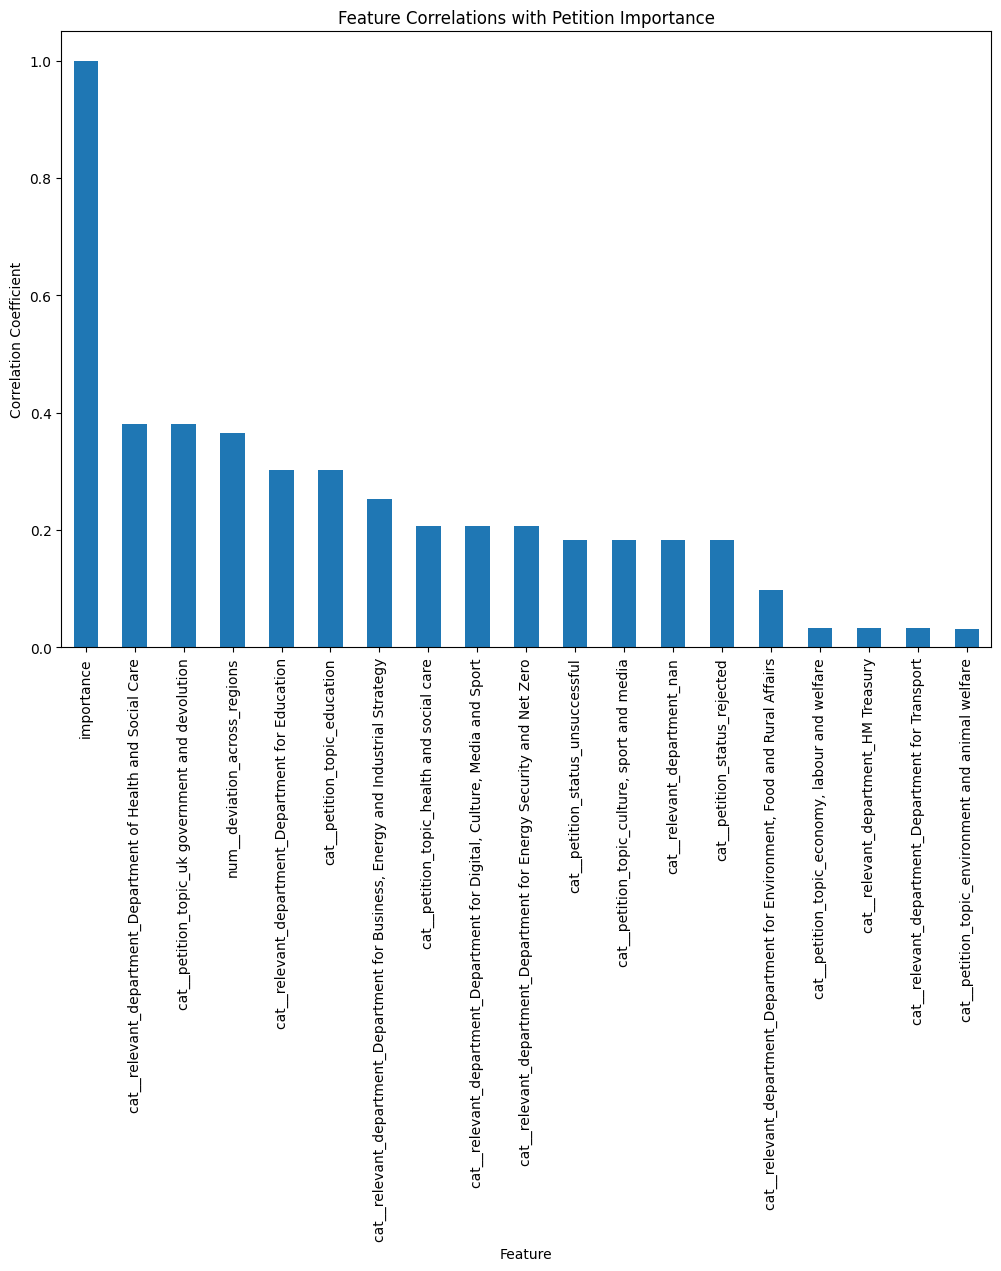

In [ ]:
# Separate labelled and unlabelled data
labeled_df = df[df['petition_importance'].notna()]
unlabeled_df = df[df['petition_importance'].isna()]

# Handle missing values in relevant columns
columns_to_process = ['relevant_department', 'deviation_across_regions',
                      'petition_status', 'petition_topic', 'petition_importance']

for col in columns_to_process:
    labeled_df[col] = labeled_df[col].dropna()

# Convert 'petition_importance' to binary labels
label_encoder = LabelEncoder()
labeled_df['petition_importance_label'] = label_encoder.fit_transform(labeled_df['petition_importance'])

# Define categorical and numerical columns
categorical_cols = ['relevant_department', 'petition_status', 'petition_topic']
numerical_cols = ['deviation_across_regions']

# Create preprocessing pipeline
# Impute numerical features before scaling
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Apply preprocessing
X = preprocessor.fit_transform(labeled_df[categorical_cols + numerical_cols])
y = labeled_df['petition_importance_label']

# Convert the sparse matrix to a dense array for correlation analysis
X_dense = X.todense()

# Create a DataFrame for correlation analysis
correlation_df = pd.DataFrame(X_dense, columns=preprocessor.get_feature_names_out())

# Add the target variable
correlation_df['importance'] = y

# Calculate correlations with the target variable
correlations = correlation_df.corrwith(correlation_df['importance'])

# Display the top correlations
print("Top correlations with petition importance:")
print(correlations.abs().sort_values(ascending=False).head(10))

# Plot correlations
plt.figure(figsize=(12, 8))
correlations.abs().sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Correlations with Petition Importance')
plt.xlabel('Feature')
plt.ylabel('Correlation Coefficient')
plt.show()

In [ ]:
# Handle missing values
for col in [
    'relevant_department', 'deviation_across_regions',
    'petition_status', 'petition_topic', 'petition_importance'
]:
    df[col] = df[col].fillna('unknown')

# Calculate text length
df['petition_text_length'] = df['petition_text'].apply(lambda x: len(str(x).split()))

# Preprocess 'has_entity'
df['has_entity'] = df['has_entity'].apply(
    lambda x: 1 if pd.notna(x) and any(keyword in str(x).lower()
    for keyword in ['event:yes', 'date:yes', 'person:yes'])
    else 0
)

print(f"Initial 'petition_importance' Distribution:\n {df['petition_importance'].value_counts()}")

Initial 'petition_importance' Distribution:
 petition_importance
unknown          8878
important          11
not_important       9
Name: count, dtype: int64


In [ ]:
# Manual labelling (Pseudo-labelling) (170 samples)
def label_importance(row):
    # Only label if currently 'unknown'
    if row['petition_importance'] == 'unknown':

        text = row['petition_text'].lower()

        # Use values with high correlation
        if row['relevant_department'] in ['Department for Education', 'Department of Health and Social Care'] or \
           row['petition_topic'] in ['uk government and devolution', 'education']:
            return 'important'

        if any(keyword in text for keyword in ['urgent', 'critical', 'emergency', 'national crisis']):
            return 'important'

        if len(text.split()) < 100 and \
           not any(keyword in text for keyword in ['government', 'parliament', 'minister']):
            return 'not_important'

    # If it's already labeled or doesn't meet criteria, return the original value
    return row['petition_importance']

unlabeled = df[df['petition_importance'] == 'unknown'].sample(700, random_state=42)
df.loc[unlabeled.index, 'petition_importance'] = unlabeled.apply(label_importance, axis=1)

In [ ]:
# Check 'petition_importance' distribution after manual labelling
df['petition_importance'].value_counts()

,count
petition_importance,
unknown,8509
important,317
not_important,72


In [ ]:
print(df[df['petition_importance'] == 'important']['petition_text'][1])

Lock NHS pay rises to increases in pay for MPs, backdated to 2015. Whenever the salaries of MPs rise, the salaries of every NHS staff member should rise by the same proportion. This should be backdated to 2015 to recognise the sacrifices of NHS staff over the pandemic and recognise the large real terms pay cut NHS staff have faced over many years. Between April 2015 and April 2020 MPs salaries have increased by £14,872. Over the same time period, most NHS staff have had real terms pay cuts.
This is because when IPSA  decides MPs' pay should rise, it happens. Whereas when the independent organisations that determine NHS staff pay release their recommendations, the Government can ignore it.
 
This is emblematic of a Government that believes there's one rule for them and another for everyone else.


In [ ]:
print(df[df['petition_importance'] == 'not_important']['petition_text'][4])

Make bank holidays a holiday. Make bank holidays a holiday please because i want bank holidays to be a holiday


In [ ]:
# Semi-Supervised Learning Setup
labeled_data = df[df['petition_importance'] != 'unknown']
unlabeled_data = df[df['petition_importance'] == 'unknown']

X_labeled = labeled_data[['petition_text', 'deviation_across_regions', 'petition_status', 'relevant_department', 'petition_topic', 'petition_text_length', 'has_entity']]
y_labeled = labeled_data['petition_importance'].map({'important':1, 'not_important':0})
X_unlabeled = unlabeled_data[['petition_text', 'deviation_across_regions', 'petition_status', 'relevant_department', 'petition_topic', 'petition_text_length', 'has_entity']]

X_train, X_test, y_train, y_test = train_test_split(
    X_labeled, y_labeled, test_size=0.2, stratify=y_labeled, random_state=42
)

# Create mapping dictionaries for categorical features
status_map = {'rejected':0, 'unsuccessful':1, 'successful_response':2, 'successful_debated':3}
dept_map = {dept:i for i, dept in enumerate(df['relevant_department'].dropna().unique())}
topic_map = {topic:i for i, topic in enumerate(df['petition_topic'].dropna().unique())}


## **Feature engineering and Encoding**

In [ ]:
# Feature Engineering for RF (Model 1)

# Create TF-IDF features for text
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

# Preprocess text for TF-IDF
X_train_text = tfidf_vectorizer.fit_transform(X_train['petition_text'])
X_test_text = tfidf_vectorizer.transform(X_test['petition_text'])

# Convert 'deviation_across_regions' to numeric, replacing 'unknown' with 0
X_train['deviation_across_regions'] = pd.to_numeric(X_train['deviation_across_regions'], errors='coerce').fillna(0)
X_test['deviation_across_regions'] = pd.to_numeric(X_test['deviation_across_regions'], errors='coerce').fillna(0)

# Numeric and categorical features
numeric_features = ['deviation_across_regions', 'petition_text_length', 'has_entity']
categorical_features = ['petition_status', 'relevant_department', 'petition_topic']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Combine TF-IDF features with other features
X_train_rf = np.hstack([X_train_text.toarray(), preprocessor.fit_transform(X_train).toarray()])
X_test_rf = np.hstack([X_test_text.toarray(), preprocessor.transform(X_test).toarray()])

## **Model building**

In [ ]:
# Random Forest Model
rf_model = make_imb_pipeline(
    SMOTE(random_state=42),
    RandomForestClassifier(random_state=42)
)

# Define hyperparameter grid for tuning
param_grid = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20],
    'randomforestclassifier__min_samples_split': [2, 5],
    'randomforestclassifier__min_samples_leaf': [1, 2]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_rf, y_train)

# Best parameters and best score
print("Best parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")
print(f"\nBest cross-validated accuracy: {grid_search.best_score_:.2f}")

# Evaluate RF model
rf_model = grid_search.best_estimator_
rf_preds = rf_model.predict(X_test_rf)

print("\nRF Model Accuracy:", accuracy_score(y_test, rf_preds))
print("\nRF Classification Report:")
print(classification_report(y_test, rf_preds))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters found:
randomforestclassifier__max_depth: None
randomforestclassifier__min_samples_leaf: 1
randomforestclassifier__min_samples_split: 2
randomforestclassifier__n_estimators: 100

Best cross-validated accuracy: 0.93

RF Model Accuracy: 0.9743589743589743

RF Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.98      0.98      0.98        64

    accuracy                           0.97        78
   macro avg       0.96      0.96      0.96        78
weighted avg       0.97      0.97      0.97        78



In [ ]:
# DistilBERT (Model 2)

# Define the ImportanceClassifier Model
class ImportanceClassifier(torch.nn.Module):
    def __init__(self, n_classes=2):
        super(ImportanceClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.numeric_layer = torch.nn.Linear(6, 32)
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size + 32, n_classes)
        self.dropout = torch.nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask, numeric_features):
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        ).last_hidden_state[:, 0, :]

        numeric_output = torch.nn.functional.relu(self.numeric_layer(numeric_features))
        combined = torch.cat((bert_output, numeric_output), dim=1)
        return self.classifier(self.dropout(combined))

# Define the Custom Dataset
class ImportanceDataset(Dataset):
    def __init__(self, df, labels, tokenizer, status_map, dept_map, topic_map):
        self.df = df
        self.labels = labels
        self.tokenizer = tokenizer
        self.status_map = status_map
        self.dept_map = dept_map
        self.topic_map = topic_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = str(self.df.iloc[idx]['petition_text'])
        deviation = self.df.iloc[idx]['deviation_across_regions']
        status = self.status_map.get(self.df.iloc[idx]['petition_status'], 0)
        dept = self.dept_map.get(self.df.iloc[idx]['relevant_department'], 0)
        topic = self.topic_map.get(self.df.iloc[idx]['petition_topic'], 0)
        text_length = self.df.iloc[idx]['petition_text_length']
        has_entity = self.df.iloc[idx]['has_entity']

        # Convert deviation to float, handle potential errors
        try:
            deviation = float(deviation)
        except (TypeError, ValueError):
            deviation = 0.0

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=128,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        numeric_features = torch.tensor([
            deviation,
            status,
            dept,
            topic,
            text_length / 1000,
            has_entity
        ], dtype=torch.float32)

        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'numeric': numeric_features
        }

        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)

        return item

# Train Model with Cross-Validation
def train_with_cross_validation(model, X_train, y_train, tokenizer, status_map, dept_map, topic_map, epochs=5, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_model = None
    best_accuracy = 0.0

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        print(f"\nFold {fold + 1}/{n_splits}")

        train_subset, val_subset = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_subset, y_val_subset = y_train.iloc[train_idx], y_train.iloc[val_idx]

        train_dataset = ImportanceDataset(train_subset, y_train_subset, tokenizer, status_map, dept_map, topic_map)
        val_dataset = ImportanceDataset(val_subset, y_val_subset, tokenizer, status_map, dept_map, topic_map)

        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

        model.to(device)
        optimizer = AdamW(model.parameters(), lr=3e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

        for epoch in range(epochs):
            model.train()
            total_loss = 0

            for batch in train_loader:
                optimizer.zero_grad()
                outputs = model(batch['input_ids'].to(device),
                                batch['attention_mask'].to(device),
                                batch['numeric'].to(device))
                loss = torch.nn.functional.cross_entropy(outputs, batch['labels'].to(device))
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            avg_train_loss = total_loss / len(train_loader)
            scheduler.step(avg_train_loss)

            # Validation
            model.eval()
            val_preds, val_labels = [], []
            with torch.no_grad():
                for batch in val_loader:
                    outputs = model(batch['input_ids'].to(device),
                                    batch['attention_mask'].to(device),
                                    batch['numeric'].to(device))
                    preds = torch.argmax(outputs, dim=1).cpu().numpy()
                    labels = batch['labels'].cpu().numpy()
                    val_preds.extend(preds)
                    val_labels.extend(labels)

            val_accuracy = accuracy_score(val_labels, val_preds)
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_train_loss:.4f} - Val Acc: {val_accuracy:.4f}")

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model = model.state_dict()

    print("\nBest validation accuracy across folds:", best_accuracy)
    model.load_state_dict(best_model)
    return model

# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Model and Tokenizer
model = ImportanceClassifier().to(device)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Train with Cross-Validation
model = train_with_cross_validation(model, X_train, y_train, tokenizer, status_map, dept_map, topic_map)

# Evaluate on Test Set
test_dataset = ImportanceDataset(X_test, y_test, tokenizer, status_map, dept_map, topic_map)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
test_preds = []
with torch.no_grad():
    for batch in test_loader:
        outputs = model(batch['input_ids'].to(device),
                        batch['attention_mask'].to(device),
                        batch['numeric'].to(device))
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        test_preds.extend(preds)


Fold 1/5
Epoch 1/5 - Loss: 0.5464 - Val Acc: 0.8095
Epoch 2/5 - Loss: 0.4075 - Val Acc: 0.8095
Epoch 3/5 - Loss: 0.2805 - Val Acc: 0.9365
Epoch 4/5 - Loss: 0.1212 - Val Acc: 0.9365
Epoch 5/5 - Loss: 0.0322 - Val Acc: 0.9524

Fold 2/5
Epoch 1/5 - Loss: 0.0465 - Val Acc: 0.9516
Epoch 2/5 - Loss: 0.0282 - Val Acc: 0.9839
Epoch 3/5 - Loss: 0.0048 - Val Acc: 0.9839
Epoch 4/5 - Loss: 0.0021 - Val Acc: 0.9839
Epoch 5/5 - Loss: 0.0011 - Val Acc: 0.9839

Fold 3/5
Epoch 1/5 - Loss: 0.0217 - Val Acc: 1.0000
Epoch 2/5 - Loss: 0.0153 - Val Acc: 1.0000
Epoch 3/5 - Loss: 0.0114 - Val Acc: 1.0000
Epoch 4/5 - Loss: 0.0020 - Val Acc: 1.0000
Epoch 5/5 - Loss: 0.0005 - Val Acc: 1.0000

Fold 4/5
Epoch 1/5 - Loss: 0.0003 - Val Acc: 1.0000
Epoch 2/5 - Loss: 0.0001 - Val Acc: 1.0000
Epoch 3/5 - Loss: 0.0001 - Val Acc: 1.0000
Epoch 4/5 - Loss: 0.0000 - Val Acc: 1.0000
Epoch 5/5 - Loss: 0.0000 - Val Acc: 1.0000

Fold 5/5
Epoch 1/5 - Loss: 0.0000 - Val Acc: 1.0000
Epoch 2/5 - Loss: 0.0000 - Val Acc: 1.0000
Epoc

## **Model evaluation**

In [ ]:
# Evaluation & Comparison

# Compare with baseline
baseline = MultinomialNB().fit(
    X_train['petition_text'].apply(lambda x: len(x)).values.reshape(-1, 1),
    y_train
)
baseline_pred = baseline.predict(X_test['petition_text'].apply(lambda x: len(x)).values.reshape(-1, 1))

# Calculate and print metrics
print(f"Baseline (Majority Class) Accuracy: {accuracy_score(y_test, [0]*len(y_test))}")
print(f"\nBaseline (Majority Class) F1-score: {f1_score(y_test, baseline_pred, average='weighted')}")
print(f"\nRF Model Accuracy: {accuracy_score(y_test, rf_preds)}")
print(f"\nRF Model F1-score: {f1_score(y_test, rf_preds, average='weighted')}")
print(f"\nDistilBERT Model Accuracy: {accuracy_score(y_test, test_preds)}")
print(f"\nDistilBERT Model F1-score: {f1_score(y_test, test_preds, average='weighted')}")

Baseline (Majority Class) Accuracy: 0.1794871794871795

Baseline (Majority Class) F1-score: 0.7396171903214157

RF Model Accuracy: 0.9743589743589743

RF Model F1-score: 0.9743589743589743

DistilBERT Model Accuracy: 0.8974358974358975

DistilBERT Model F1-score: 0.9000407000407


In [ ]:
# Generate classification report
print("\nClassification Report for DistilBERT Model:")
print(classification_report(y_test, test_preds))


Classification Report for DistilBERT Model:
              precision    recall  f1-score   support

           0       0.69      0.79      0.73        14
           1       0.95      0.92      0.94        64

    accuracy                           0.90        78
   macro avg       0.82      0.85      0.83        78
weighted avg       0.90      0.90      0.90        78



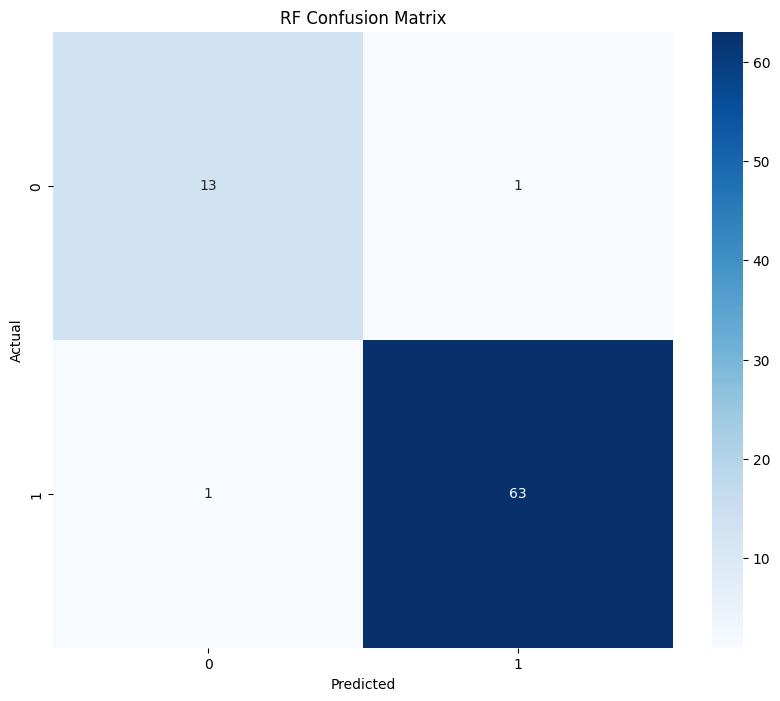

In [ ]:
# Generate RF Confusion matrix
conf_matrix = confusion_matrix(y_test, rf_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=grid_search.classes_, yticklabels=grid_search.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('RF Confusion Matrix')
plt.show()

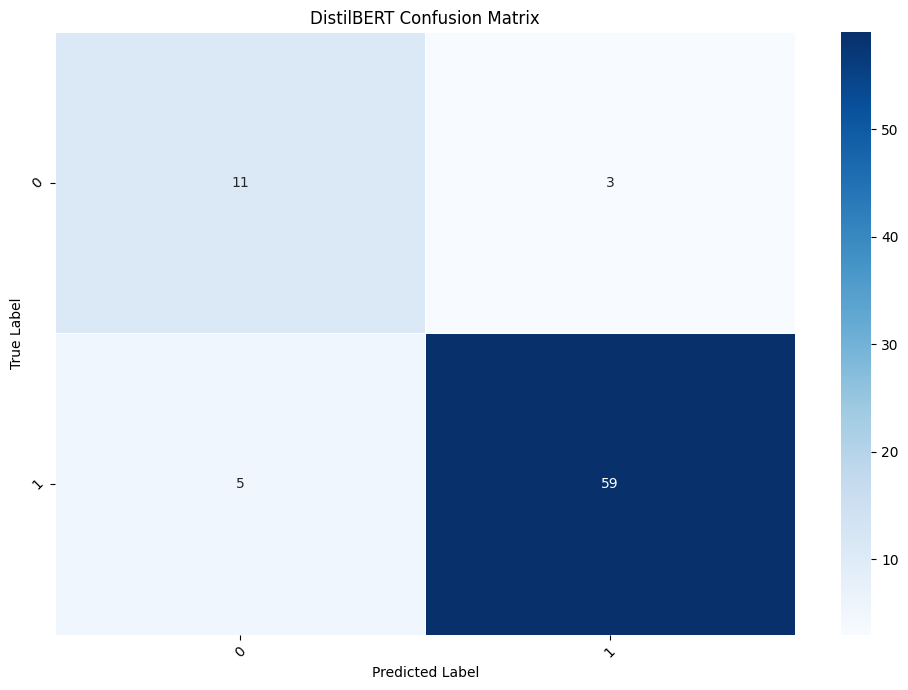

In [ ]:
true_labels = []
final_preds = []

# Evaluate DistilBERT Model
model.eval()

# Create DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Disable gradient calculations for evaluation
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        numeric_features = batch['numeric'].to(device)
        labels = batch['labels'].to(device)

        # Get model outputs
        outputs = model(input_ids, attention_mask, numeric_features)

        # Convert logits to predicted class indices
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        final_preds.extend(preds)



# Generate DistilBERT Confusion Matrix
cm = confusion_matrix(true_labels, final_preds)

# Define labels, assuming 0 and 1 are your class labels
label_map = {0: 'not_important', 1: 'important'}  # Define label_map here
labels = list(label_map.keys())

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels, linewidths=0.5)

plt.title('DistilBERT Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()